Demo 7 –Centered Initialized Affine Transform
200345N

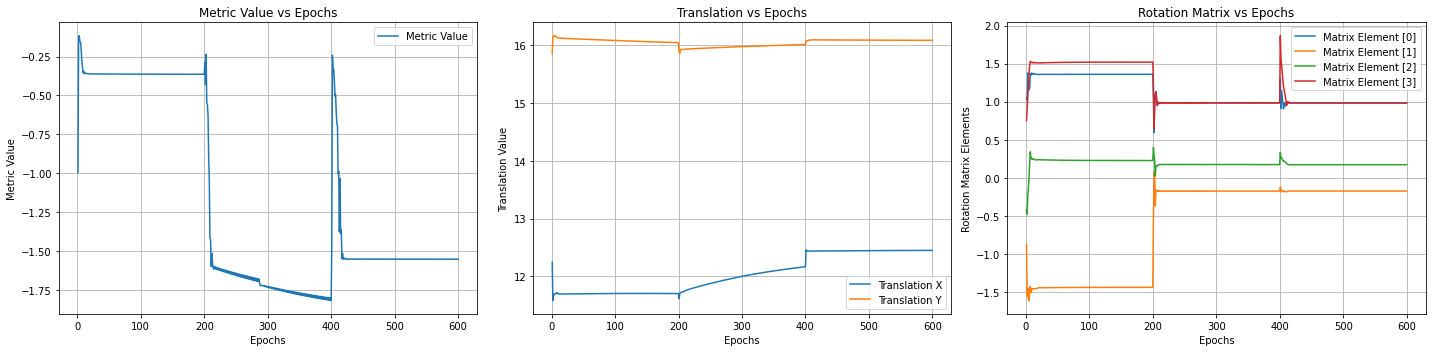

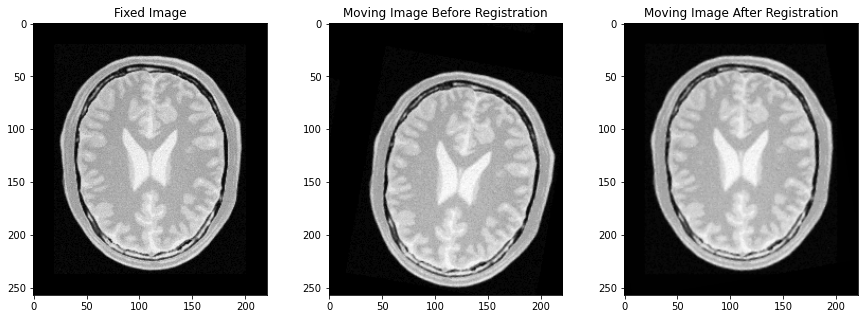

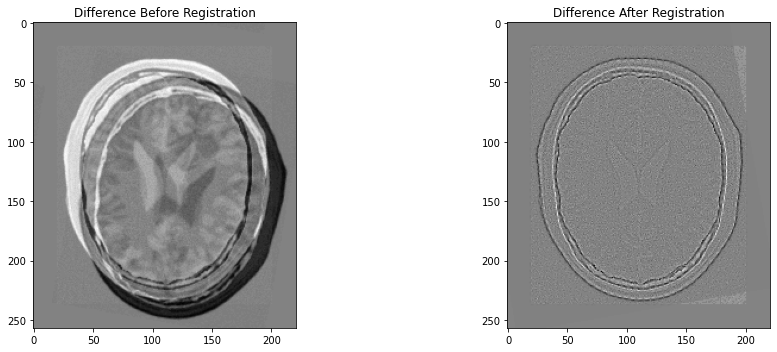

Iterations = 200
Final Metric = -1.5530
Center = (111.2036, 131.5910) 
Translation = (12.4514, 16.0823) 
Affine scales = (0.99800, 0.99882)
Angle = -10.0031 degrees


<itk.itkImageRegistrationMethodv4Python.itkImageRegistrationMethodv4REGv4F2F2; proxy of <Swig Object of type 'itkImageRegistrationMethodv4REGv4F2F2 *' at 0x0000021FE14BE780> >

In [1]:
import itk
import matplotlib.pyplot as plt
import numpy as np

def perform_affine_registration(fixed_image_path, moving_image_path):
    # Set pixel type and dimension
    PixelType = itk.ctype("float")
    Dimension = 2
    
    # Read the fixed and moving images
    fixed_image = itk.imread(fixed_image_path, PixelType)
    moving_image = itk.imread(moving_image_path, PixelType)

    FixedImageType = itk.Image[PixelType, Dimension]
    MovingImageType = itk.Image[PixelType, Dimension]

    # Define the affine transform type
    TransformType = itk.AffineTransform[itk.D, Dimension]
    transform = TransformType.New()

    metric_values = []
    rotation_matrix_values = []
    translation_x_values = []
    translation_y_values = []

    # Callback to observe metrics during optimization
    def observer():
        current_parameters = optimizer.GetCurrentPosition()
        matrix_elements = [current_parameters.GetElement(i) for i in range(4)]  # First 4 elements are the rotation/scaling matrix
        translation_x = current_parameters.GetElement(4)
        translation_y = current_parameters.GetElement(5)
        metric_value = optimizer.GetValue()

        metric_values.append(metric_value)
        rotation_matrix_values.append(matrix_elements)
        translation_x_values.append(translation_x)
        translation_y_values.append(translation_y)

    # Set up optimizer (RegularStepGradientDescent)
    optimizer = itk.RegularStepGradientDescentOptimizerv4.New(
        LearningRate=1.0,
        MinimumStepLength=0.0001,
        NumberOfIterations=200
    )
    optimizer.AddObserver(itk.IterationEvent(), observer)

    # Use Mattes Mutual Information as the similarity metric
    metric = itk.MattesMutualInformationImageToImageMetricv4[FixedImageType, MovingImageType].New()
    metric.SetNumberOfHistogramBins(50)

    # Registration method
    registration = itk.ImageRegistrationMethodv4.New(
        FixedImage=fixed_image,
        MovingImage=moving_image,
        Metric=metric,
        Optimizer=optimizer,
        InitialTransform=transform
    )

    # Compute center of mass for the fixed and moving images using ImageMomentsCalculator
    moments_calculator_fixed = itk.ImageMomentsCalculator[FixedImageType].New()
    moments_calculator_fixed.SetImage(fixed_image)
    moments_calculator_fixed.Compute()
    center_of_mass_fixed = moments_calculator_fixed.GetCenterOfGravity()

    moments_calculator_moving = itk.ImageMomentsCalculator[MovingImageType].New()
    moments_calculator_moving.SetImage(moving_image)
    moments_calculator_moving.Compute()
    center_of_mass_moving = moments_calculator_moving.GetCenterOfGravity()

    # Initialize the affine transform using the center of mass of the fixed image
    transform.SetCenter(center_of_mass_fixed)

    # Set the initial translation to align centers of mass
    transform.SetTranslation([center_of_mass_moving[i] - center_of_mass_fixed[i] for i in range(Dimension)])

    # Set the initial transform in the registration method
    registration.SetInitialTransform(transform)

    # Set scales for the optimizer (rotation, scaling, translation)
    optimizer_scales = [1.0, 1.0, 1.0, 1.0, 0.1, 0.1]  # Scaling for each parameter
    optimizer.SetScales(itk.OptimizerParameters[itk.D](optimizer_scales))

    # Perform the registration
    registration.Update()

    # Resample the moving image to match the fixed image's grid after registration
    resampler = itk.ResampleImageFilter.New(Input=moving_image, Transform=registration.GetTransform(), UseReferenceImage=True)
    resampler.SetReferenceImage(fixed_image)
    resampler.SetInterpolator(itk.LinearInterpolateImageFunction.New(moving_image))
    resampler.Update()
    resampled_moving_image = resampler.GetOutput()

    # Compute difference images before and after registration
    subtract_filter_before = itk.SubtractImageFilter.New(Input1=fixed_image, Input2=moving_image)
    subtract_filter_before.Update()
    difference_before_registration = subtract_filter_before.GetOutput()

    subtract_filter_after = itk.SubtractImageFilter.New(Input1=fixed_image, Input2=resampled_moving_image)
    subtract_filter_after.Update()
    difference_after_registration = subtract_filter_after.GetOutput()

    # Convert the ITK images to NumPy arrays for visualization
    difference_before_registration_array = itk.GetArrayViewFromImage(difference_before_registration)
    difference_after_registration_array = itk.GetArrayViewFromImage(difference_after_registration)

    # Plotting metrics over iterations
    epochs = list(range(1, len(metric_values) + 1))

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, metric_values, label="Metric Value")
    plt.xlabel('Epochs')
    plt.ylabel('Metric Value')
    plt.title('Metric Value vs Epochs')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, translation_x_values, label="Translation X")
    plt.plot(epochs, translation_y_values, label="Translation Y")
    plt.xlabel('Epochs')
    plt.ylabel('Translation Value')
    plt.title('Translation vs Epochs')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, [r[0] for r in rotation_matrix_values], label="Matrix Element [0]")
    plt.plot(epochs, [r[1] for r in rotation_matrix_values], label="Matrix Element [1]")
    plt.plot(epochs, [r[2] for r in rotation_matrix_values], label="Matrix Element [2]")
    plt.plot(epochs, [r[3] for r in rotation_matrix_values], label="Matrix Element [3]")
    plt.xlabel('Epochs')
    plt.ylabel('Rotation Matrix Elements')
    plt.title('Rotation Matrix vs Epochs')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plotting the fixed, moving, and difference images
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(itk.GetArrayViewFromImage(fixed_image), cmap="gray")
    plt.title("Fixed Image")

    plt.subplot(1, 3, 2)
    plt.imshow(itk.GetArrayViewFromImage(moving_image), cmap="gray")
    plt.title("Moving Image Before Registration")

    plt.subplot(1, 3, 3)
    plt.imshow(itk.GetArrayViewFromImage(resampled_moving_image), cmap="gray")
    plt.title("Moving Image After Registration")

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(difference_before_registration_array, cmap="gray")
    plt.title("Difference Before Registration")

    plt.subplot(1, 2, 2)
    plt.imshow(difference_after_registration_array, cmap="gray")
    plt.title("Difference After Registration")

    plt.tight_layout()
    plt.show()

    # Extract final transformation parameters after registration
    final_parameters = transform.GetParameters()  
    matrix_elements = [final_parameters[i] for i in range(4)]  # First 4 elements are the affine matrix
    translation_x = final_parameters[4]
    translation_y = final_parameters[5]

    # Extracting the center of the transformation
    center = transform.GetCenter()

    # Calculate the affine rotation angle from the matrix
    affine_angle = np.arctan2(matrix_elements[1], matrix_elements[0]) * (180.0 / np.pi)  # Convert to degrees

    # Calculate affine scales based on the matrix elements
    affine_scale_x = np.sqrt(matrix_elements[0] ** 2 + matrix_elements[1] ** 2)
    affine_scale_y = np.sqrt(matrix_elements[2] ** 2 + matrix_elements[3] ** 2)

    # Output results
    print(f"Iterations = {optimizer.GetCurrentIteration()}")
    print(f"Final Metric = {metric_values[-1]:.4f}")
    print(f"Center = ({center[0]:.4f}, {center[1]:.4f}) ")
    print(f"Translation = ({translation_x:.4f}, {translation_y:.4f}) ")
    print(f"Affine scales = ({affine_scale_x:.5f}, {affine_scale_y:.5f})")
    print(f"Angle = {affine_angle:.4f} degrees")

    return registration

# File paths to the images
fixed_image_path = "BrainProtonDensitySliceBorder20.png"
moving_image_path = "BrainProtonDensitySliceR10X13Y17.png"

# Perform registration
perform_affine_registration(fixed_image_path, moving_image_path)
